In [63]:
import os
import numpy as np
import cv2 as cv
import pandas as pd
import torch
import torchvision.transforms as transforms
from PIL import Image
from catalyst.dl.utils import UtilsFactory
from tqdm import tqdm

import argparse

from pytorch.models.utils import get_model

In [2]:
test_df_path = '../data/test_df.csv'
dataset_path = '../data'
network = 'linknet'
model_weights_path = '../data/best.pth'

In [3]:
def get_filenames(path):
    return tuple(os.walk(path))[0][2]


def get_image(image_path, filename):
    image_path = os.path.join(image_path, filename)
    img = Image.open(image_path)

    return transforms.ToTensor()(img)


def load_model(network, model_weights_path):
    model = get_model(network)
    checkpoint = torch.load(model_weights_path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model.eval()


def predict(model, image_tensor, input_shape=(1, 3, 224, 224)):
    prediction = model(image_tensor.view(*input_shape))
    return torch \
        .sigmoid(prediction.view(*input_shape[2:])) \
        .detach().numpy()


def get_predictions(network, model_weights_path, images_path):
    model = load_model(network, model_weights_path)
    predictions = []
    for filename in tqdm(get_filenames(images_path)):
        predictions.append(
            predict(model, get_image(images_path, filename)))
        
    return predictions


def save_predictions(predictions, filenames, save_path):
    predictions_path = os.path.join(save_path, 'predictions')
    
    if not os.path.exists(predictions_path):
        os.mkdir(predictions_path)
        print('Pediction directory created.')
        
    for pred, filename in zip(predictions, filenames):
        cv.imwrite(
            os.path.join(
                predictions_path,
                filename + '.png'),
            pred * 255)
    
    print('Predictions saved.')
    return predictions_path

In [4]:
from preprocessing import image_division

In [5]:
tif_path = '../../input/20160103_66979721-be1b-4451-84e0-4a573236defd_rgb.tif'
pieces_path = '../data/pieces'
w, h = 224, 224

In [ ]:
#image_division.divide_into_pieces(tif_path, pieces_path, w, h)

In [6]:
images_path = os.path.join(pieces_path, 'images')
pieces_names = tuple(os.walk(images_path))[0][2]
pieces_names = list(map(lambda x: x[:-5], pieces_names))

In [ ]:
#predictions = get_predictions(network, model_weights_path, images_path)

In [ ]:
#predictions_path = save_predictions(predictions, pieces_names, dataset_path)

In [7]:
predictions_path = os.path.join(dataset_path, 'predictions')

In [60]:
def concat_predictions(predictions_path, pieces_info_path):
    pieces_info = pd.read_csv(pieces_info_path, index_col=0)
    
    result = []
    row = []
    for piece in tqdm(pieces_info.iterrows()):
        if piece[1]['start_x'] == 0 and piece[1]['start_y'] != 0:
            result.append(row)
            row = []
        filename = piece[1]['piece_image'][:-5] + '.png'
        with Image.open(os.path.join(predictions_path, filename)) as img:
            pred = transforms.ToTensor()(img).numpy()[0]
        row.append(pred)
            
    result.append(row)
    
    return result
            
        

In [61]:
res = concat_predictions(
    predictions_path,
    os.path.join(pieces_path, 'image_pieces.csv'))

2401it [00:01, 1510.94it/s]


In [76]:
pred = []
for i in res:
    pred.append(np.concatenate(i, axis=1))
    
result = np.concatenate(pred, axis=0)

In [71]:
import matplotlib.pyplot as plt

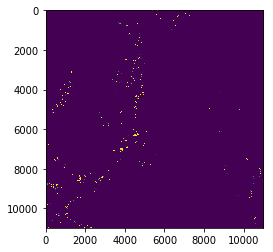

In [77]:
plt.imshow(result)

In [79]:
import imageio
save_path = os.path.join(dataset_path, 'predicted_mask.png')
imageio.imwrite(save_path, result)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
